# Optimization and Deep Learning. Lab 1 - Solution

Gradient Descent, Stochastic Gradient Descent.

In [ ]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%precision 2


import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)
npt_config = {'session_name': 'Lab1-Map545','session_owner': 'aymeric', } #do not change those lines

npt_config['sender_name'] = input("Name:")
send('started',0)

# Load the data + Exploration

In [246]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [247]:
y.shape, tx.shape

((10000,), (10000, 2))

In [248]:
tx[0:10]

array([[ 1.  ,  1.94],
       [ 1.  ,  0.63],
       [ 1.  ,  2.01],
       [ 1.  ,  1.39],
       [ 1.  ,  0.91],
       [ 1.  ,  0.23],
       [ 1.  ,  0.63],
       [ 1.  ,  0.51],
       [ 1.  ,  0.17],
       [ 1.  , -0.76]])

In [249]:
(np.mean(tx[:,1]),np.std(tx[:,1]))

(-0.00, 1.00)

Hessian matrix of my optimzation problem $\frac{1}{2n}|| Xw-Y||^2$

Gradient : $ \frac{1}{n} X^T (Ww-Y)$

Hessian $\frac{1}{n} X^TX$

In [250]:
n_s = y.shape
tx.T@tx/n_s

array([[ 1.00e+00, -1.28e-15],
       [-1.28e-15,  1.00e+00]])

Hessain is idendity :
- largest eigenvalue is 1
- smallest eigenvalue is 1

Condition number $\kappa = L/\mu$ is 1 

When $\kappa=1$ for **quadratic functions** for $\gamma=1$, GD converges in 1 step !!


**Reason :** Newton method always converges in **one step** for quadraitcs

#### Extension


To avoid this problem, we can use a non-diagonal covariance matrix, by having 2 explanatory variables that are not independent. For example, we can use height and height^3. You can re-run the entire lab with $tx$ re-defined with those two features.

In [251]:
feature_height2 = (tx[:,1]**3)
feature_height2 = 1/ np.std(feature_height2)*(feature_height2-np.mean(feature_height2))
tx2 = np.concatenate((tx, (feature_height2).reshape(-1,1)), axis=1)
tx2 = tx2[:, 1:]

In [252]:
n_s = y.shape
tx2.T@tx2/n_s
# note that directly replacing tx by tx2 does not directly work in the following code

array([[1.  , 0.81],
       [0.81, 1.  ]])

This matrix has eigenvalues 1,81 and 0,19, thus a condition number of 9. We expect to have a maximal step size of 2/L, with L=1,81 thus ~1.1

# Computing the Cost Function
Fill in the `compute_cost` function below:

In [253]:
def calculate_mse(e):
    """Calculate the mse for vector e."""
    return 1/2*np.mean(e**2)


def calculate_mae(e):
    """Calculate the mae for vector e."""
    return np.mean(np.abs(e))


def compute_loss(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    e = y - tx.dot(w)
    return calculate_mse(e)

send(compute_loss,1)

<Response [400]>

# Optimal solution
In Least squares regression, we have an exact expression for the optimal value of the parameter.

While with the small dataset we are using, it is possible to compute it, it requires to compute the inverse of a $d \times d$ matrix, which is prohibitive in most high dimensionnal settings: in those situations, it is impossible to know precisely what the value at the otpimum is.

In [254]:
w_star = np.linalg.inv(tx.T@tx)@(tx.T@(y))
w_star

array([73.29, 13.48])

In [255]:
loss_at_opt = compute_loss(y,tx, w_star)

% precision 2
loss_at_opt

15.39

The optimal loss is 15.3858878688294. It is not surprising that the loss at the optimum is not 0: on the contrary, it would be very suprising if the loss was 0: it would mean that there exist $w^*$ such that for any $i\in \lbrace 1, \dots, n \rbrace$, $y_i = w_0^*+ w_1^* x_i$: in other words, knowing the height of someone would allow to know his weight excatly.


In the following, we will compute and plot the **excess loss** $L(w)-L(w^*)$ instead of the loss, as most theoretical results provide guarantees on the excess of loss.


# Grid Search

Fill in the function `grid_search()` below:

In [256]:
# from costs import *

def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    loss = np.zeros((len(w0), len(w1)))
    # compute loss for each combinationof w0 and w1.
    for ind_row, row in enumerate(w0):
        for ind_col, col in enumerate(w1):
            w = np.array([row, col])
            loss[ind_row, ind_col] = compute_loss(y, tx, w)-loss_at_opt
    return loss

Let us play with the grid search demo now!

Grid Search: loss*=0.1728154997801301, w0*=72.72727272727272, w1*=13.636363636363626, execution time=0.706 seconds


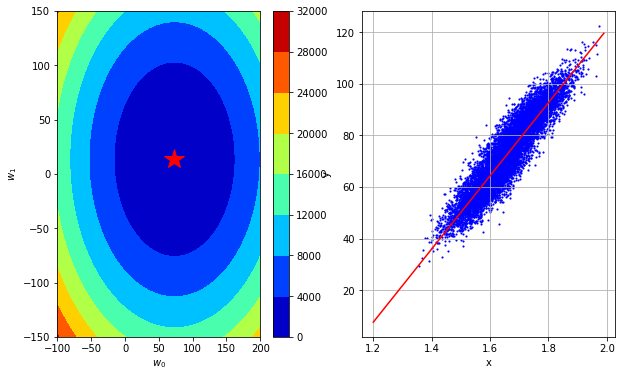

In [257]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=100)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

## Commentaires:

- the finner the grid, the more precise the solution is. However, the computational time increases very rapidly without a large improvement in the error: the error is divided by 20 while the time is multiplied by 120 between a grid of size 10 and a 100.

| Grid size| 10| 100 | 1000 |
| --- | --- | --- |
| Time |0.12 |0.56s   | 60s|
| Precision |27 |0.17    | 0.007|


- in higher dimension, the complexity would increse even more, and this method cannnot be used.

# Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [258]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

send(compute_gradient, 2)

<Response [400]>

In [259]:
compute_gradient(y, tx, w_star)

(array([ 2.98e-14, -1.95e-15]),
 array([10.32, -8.06, -3.84, ..., -6.21, -8.25, -6.2 ]))

In [260]:
compute_gradient(y,tx, [100,20])

(array([26.71,  6.52]),
 array([-29.06, -38.86, -43.66, ..., -28.68, -39.47, -25.41]))

Please fill in the functions `gradient_descent` below:

In [261]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute loss, gradient
        grad, err = compute_gradient(y, tx, w)
        loss = calculate_mse(err)-loss_at_opt
        # gradient w by descent update
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

send(gradient_descent, 3)

<Response [400]>

Test your gradient descent function through gradient descent demo shown below:

In [316]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 11
gamma = 0.8

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time=%.3f seconds for %i iterations" %(exection_time, max_iters))
send("Gradient Descent: execution time=%.3f seconds for %i iterations" %(exection_time, max_iters), 4)

Gradient Descent(0/10): loss=2776.850824890338, w0=58.63513760168412, w1=10.783769947991162
Gradient Descent(1/10): loss=111.07403299561417, w0=70.36216512202097, w1=12.940523937589457
Gradient Descent(2/10): loss=4.442961319824597, w0=72.70757062608834, w1=13.371874735509127
Gradient Descent(3/10): loss=0.1777184527929876, w0=73.17665172690182, w1=13.458144895093064
Gradient Descent(4/10): loss=0.007108738111719859, w0=73.27046794706452, w1=13.475398927009852
Gradient Descent(5/10): loss=0.00028434952446865225, w0=73.28923119109706, w1=13.47884973339321
Gradient Descent(6/10): loss=1.1373980978390819e-05, w0=73.29298383990356, w1=13.47953989466988
Gradient Descent(7/10): loss=4.5495923828298146e-07, w0=73.29373436966486, w1=13.479677926925214
Gradient Descent(8/10): loss=1.8198369033939343e-08, w0=73.29388447561712, w1=13.479705533376281
Gradient Descent(9/10): loss=7.279368219315074e-10, w0=73.29391449680757, w1=13.479711054666495
Gradient Descent(10/10): loss=2.9118041311448906e-11,

<Response [400]>

In [317]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

A Jupyter Widget

<function __main__.plot_figure>

Interesting exercise: Rerun everything with height^2 as feature:
1111111, height
height, height^2  ---> Hessian is not identity

**Evolution of the excess loss as a function of the number of iterations**

In [318]:
gradient_losses

[2776.85, 111.07, 4.44, 0.18, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]

<Response [400]>

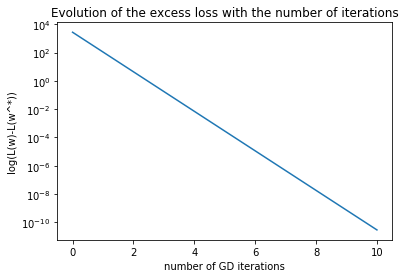

In [319]:
plt.semilogy(gradient_losses)
plt.title('Evolution of the excess loss with the number of iterations')
plt.xlabel('number of GD iterations')
plt.ylabel('log(L(w)-L(w^*))')
send(plt,5)

- step 0.1 -  slope 2/30
- step 0.2  - slope 5/30

rate theory give excess risk (after k iteration) $F(w_k)- F(w*) \le ||w_0-w*||^2 (1-\gamma \mu)^k$
$$log (F(w_k)- F(w*) )\le k \log(1-\gamma \mu) + log( ||w_0-w*||^2) $$

We can make the following remarks:
- the excess loss decays at an exponential rate, as predicted by theory:
$$L(w_t)-L(w^*) \le \frac{L}{2} \left(1-\gamma {\mu}\right)^t ||w_0-w^*||^2$$

- an exponential rate means that the error is **squared** when we double the number of iterations. Here for example, the excess loss is 0.0163 after 5 iterations, 9.68e-08 after 10 iterations, 3.55e-15 after 20 iterations


- in semi-log scale, we expect to have a **linear function**: this is what we observe on the graph above
$$\log\left(L(w_t)-L(w^*)\right) \le C -\gamma\mu t $$

- the slope of the line should be $\gamma \mu$. On the graph above, we can check that the log excess loss, decays from $10^2$ to  $ 10^{-14}$ in 30 iterations, (slope -16/30) with a step size 0.5, and $\mu=1$. The theoretical rate is verified.


**Maximum step size**:
- as predicted by theory, there exists a maximum step size: if the step size is larger than $2/L$, the GD algo diverges very quickly.

- Here, it is easy to check that the smoothness of the funciton is 1, thus the maximal step size is 2: the Hessian matrix $tx.T \times   tx$ is identity (because the data has been standardised and we have only 2 dimensions).

| GD error after | 5 iterations | 10 iterations |
|--- |---|---|---|
|$\gamma = 0.5$ | 2 |0.002|
|$\gamma = 1.5$ | 2.7| 0.002|
|$\gamma = 1.9$ |900 |337|
|$\gamma = 2$ |2776 |2776|
|$\gamma = 2.1$ | 7000 | 19000|

- We can also notice that for a step size of 2, the error is constant: indeed, the algorithm oscillates between 2 models, that have the same loss.

**Change the step size**
- how does the error vary with the step  size
- what is the maximal  step size (fill the following cell  to submit your answer


Max step size is 2/L = 2/1 = 2 as L is 1. 

In [266]:

send('the maximal step size is 2',6)

<Response [400]>

# Stochastic gradient descent

Below, we implement several different strategies fr the step size sequence. An efficient one is to use (ONLY for QUADRATICS !) constants steps and averaging...

In [137]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

send(compute_stoch_gradient,7)

from tqdm import tqmd 

def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    wave = initial_w
     
    
    
    for n_iter in tqdm(range(max_iters)):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            grad, _ = compute_stoch_gradient(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            
            w = w - gamma * grad  # CONSTANt STEP SIZE
            
#             w = w - gamma/np.sqrt(n_iter+1) * grad # DECAYING STEPS 
            
            wave = n_iter/(n_iter+1)*wave+ 1/(n_iter+1)*w 
            # THEOREM this morning POLYAK RUPPERT EVRAGING
            
            # calculate loss
            loss = compute_loss(y, tx, wave)-loss_at_opt
            # store w and loss
            ws.append(wave)
            losses.append(loss)

    print("SGD({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

send(stochastic_gradient_descent, 8)

<Response [200]>

In [267]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 100000
gamma = 0.5
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution ime=%.3f seconds for %i iterations" %(exection_time, max_iters))
send("SGD: execution ime=%.3f seconds for %i iterations" %(exection_time, max_iters),9)

SGD(99999/99999): loss=0.00021510993332540806, w0=71.1225466918326, w1=11.96081458639145
SGD: execution ime=63.530 seconds for 100000 iterations


<Response [400]>

Passes on the data after 10 000 iterations of SGD?
- 1 
Same theoretical complexity as GD for one step


In [268]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

A Jupyter Widget

<function __main__.plot_figure>

<Response [400]>

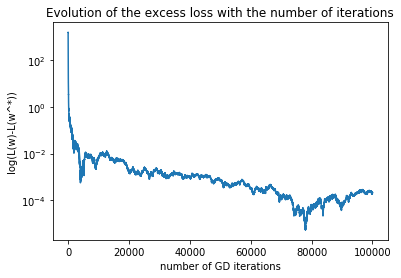

In [269]:
plt.semilogy(sgd_losses)
plt.title('Evolution of the excess loss with the number of iterations')
plt.xlabel('number of GD iterations')
plt.ylabel('log(L(w)-L(w^*))')
send(plt,5)

**Comments on the algorithm:**
- in order to improve convergence, we use decaying steps, $\gamma_k\varpropto 1/\sqrt{k}$. using small step size reduces the impactof the noise in the gradients.


- moreover, as suggested by the result in the lecture notes, we  compute the loss at the **averaged iterate**: $$\bar w_t= \frac{1}{t} \sum_{i=1}^t w_i$$

- this reduces the effect of the noise and improves a lot the convergence

- this averaged point can be computed online: $$\bar w_t= \frac{t-1}{t} \bar w_{t-1} +\frac{1}{t} w_t$$



**Comments on the convergence of the algorithm:**
    
- the convergence is much slower that GD in terms of number of iterations, but each iteration only uses 1 observation, while GD uses the 10 000 observations at each step. 
    
- in other words, the complexity of 1 step of GD is the same as the complexity of 10 000 steps of SGD

- for a step size of 1, the loss is 0.003 after 10000 iterations (one epoch), while it is 600 after 1 GD step (also one pass on all gradients)



**SGD converges much faster that GD if we want a low precision**

**However, GD will reach a high precision (e.g., $10^{-15}$) faster than SGD**

**In machine learning, we do not care too much about very high precision: the empirical risk minimization problem that we are solving is itself only an approximation of the unknown (true) generalization risk. SGD is thus the algorithm of choice.**

**Questions**:
- change the step size to a decaying sequence of step size. What choice do you recommend?
- what modification of the final iterate would you recommend to improve convergence? 

- What is the complexity per iteration of GD, SGD?
- Compare the theoretical complexity and the time required per iteration for the algorithm




**Plot:**
- Represent both your best version (choice of step size sequence) and  of SGD as a function of the theoretical complexity

- Represent both your best version (choice of step size sequence) and  of SGD as a function of the time taken

Try to choose the best parameters, for the axis, etc. Send us your best plot via the ``send'' below

In [54]:
# Plotting errors in that cell




# Your bert plot
send(plt, 10)




<Response [200]>

<Figure size 432x288 with 0 Axes>

<Response [400]>

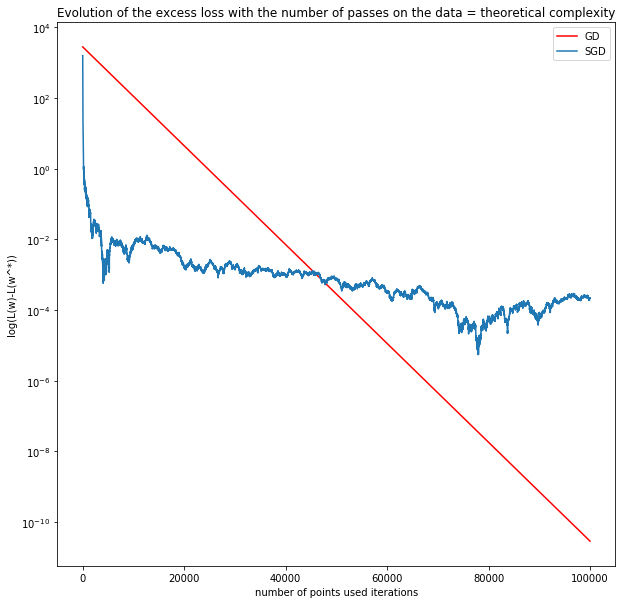

In [333]:
plt.figure(figsize=(10,10))
plt.semilogy(n_s*np.arange(0,11), gradient_losses, 'r', label='GD')
plt.semilogy(sgd_losses, label='SGD')
plt.legend()
plt.title('Evolution of the excess loss with the number of passes on the data = theoretical complexity')
plt.xlabel('number of points used iterations')
plt.ylabel('log(L(w)-L(w^*))')
send(plt,10)

### Interpretation:
- SGD is faster during the first iterations
- GD is fatser and converges better for high precision